In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, CustomLoss, get_data, get_datasets

import sys
sys.path.append("../")

folder = ""
all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images)

bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, "alpha_1")
ensemble = ensemble
ensemble.cuda();

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_k.shape

torch.Size([21, 1])

In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        train_pred = torch.cat([ensemble[i](train_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len(ensemble))])
        train_pred = torch.transpose(train_pred.squeeze(), 0,1)
        train_pred = train_pred.cpu().detach()

        test_pred = torch.cat([ensemble[i](test_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len(ensemble))])
        test_pred = torch.transpose(test_pred.squeeze(), 0,1)
        test_pred = test_pred.cpu().detach()

        torch.save(train_pred, "train_pred_images.pt")
        torch.save(test_pred, "test_pred_images.pt")
    else:
        train_pred = torch.load("train_pred_images.pt")
        test_pred = torch.load("test_pred_images.pt")

In [5]:
print(test_pred.shape)
print(test_im.shape)


torch.Size([10, 5, 180, 180])
torch.Size([10, 4, 180, 180])


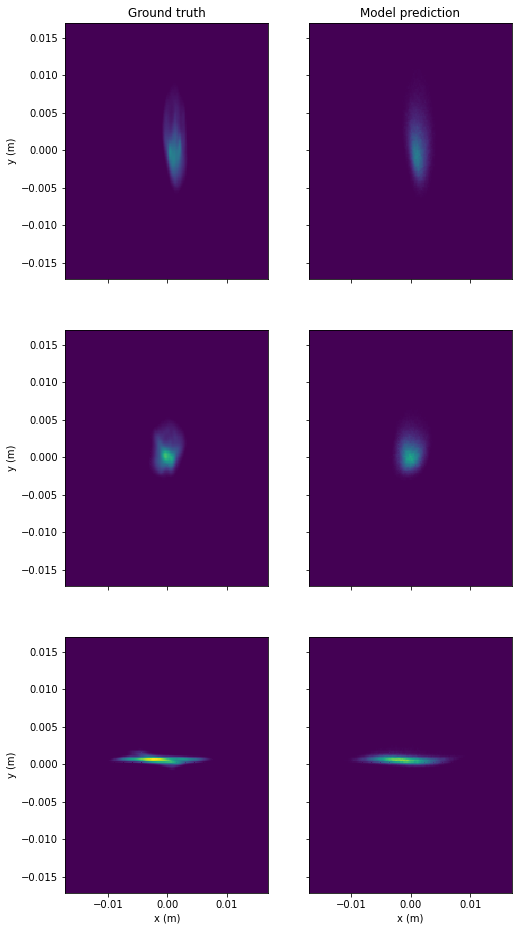

In [6]:
from visualization import compare_images
fig = compare_images(xx, train_pred[::4,0], train_im[::4,0])
fig.set_size_inches(8,16)

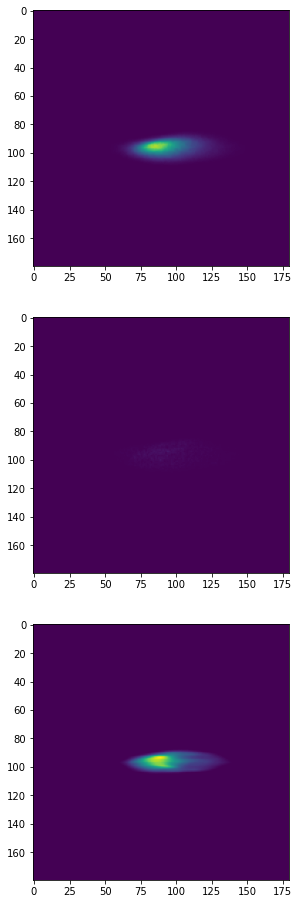

In [7]:
import matplotlib.pyplot as plt

def apply_filter(X):
    return X#ndimage.median_filter(X, size=3)

fig,ax = plt.subplots(3,1)
fig.set_size_inches(8,16)
vmax = test_im[0][0].max()
mean = torch.mean(test_pred, dim=1)[0]
std = torch.std(test_pred, dim=1)[0]
ax[0].imshow(mean, vmax = vmax)
ax[1].imshow(std, vmax = vmax)
ax[2].imshow(test_im[0][0], vmax = vmax)

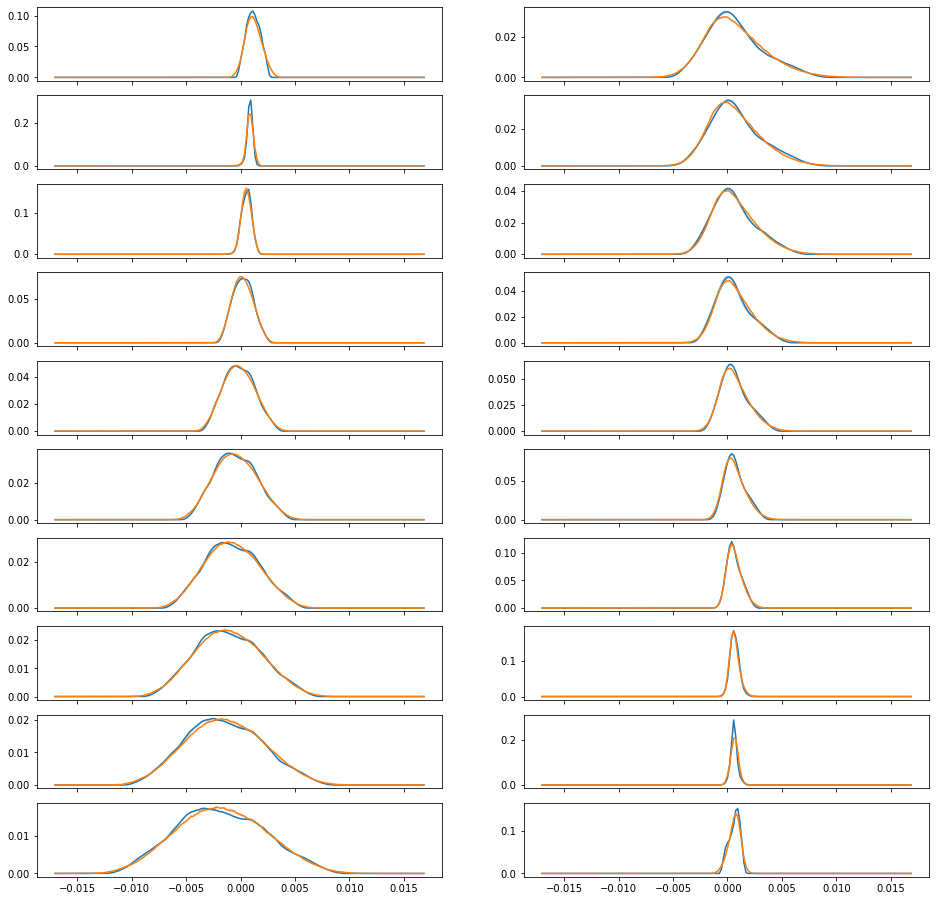

In [8]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], test_im, test_pred)
fig.set_size_inches(16,16)

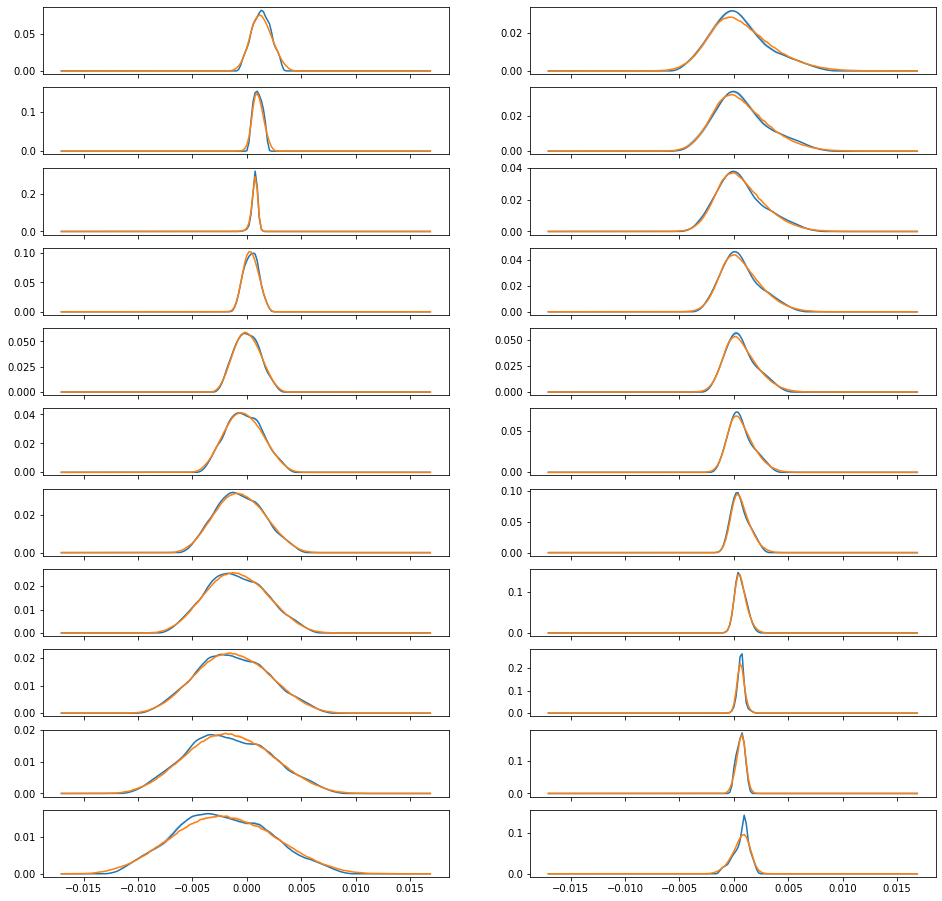

In [9]:
# compare projections
from visualization import compare_image_projections

fig = compare_image_projections(xx[0].T[0], train_im, train_pred)
fig.set_size_inches(16,16)

<AxesSubplot:>

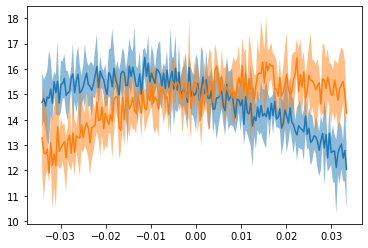

In [10]:
# plot reconstructed beam dist
from visualization import add_projection
beams = [ele.beam_generator() for ele in ensemble]

fig,ax = plt.subplots()
#add_projection(ax, "x", beams, xx[0].T[0])
#add_projection(ax, "y", beams, xx[0].T[0])
#add_projection(ax, "px", beams, xx[0].T[0])
#add_projection(ax, "py", beams, xx[0].T[0])
add_projection(ax, "z", beams, xx[0].T[0]*2)
add_projection(ax, "pz", beams, xx[0].T[0]*2)